In [1]:
#importing necessary libraries
import numpy as np
import pandas as pd
import seaborn as sns
#sns.set(color_codes = True)
import matplotlib.pyplot as plt
%matplotlib inline
import math
from IPython.display import display
from sklearn.utils import resample
from sklearn.metrics import roc_auc_score,roc_curve,classification_report,confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from imblearn.datasets import make_imbalance
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
print('Numpy version', np.__version__)
print('Pandas version', pd.__version__)
print('Seaborn version',sns.__version__)

Numpy version 1.19.2
Pandas version 1.3.5
Seaborn version 0.10.1


In [2]:
# Customer churn prediction for South Asian Telecom Operator
df_churn = pd.read_csv('South Asian Wireless Telecom Operator (SATO 2015).csv')

In [3]:
# to display all columns in the dataset
pd.options.display.max_columns = None

In [4]:
# Function to detect missing values and duplicate records

def missing_duplicates(col):
    if col.isnull().sum().sum() == 0:
        print('There are no missing values in the dataset')
    else:
        print('There are missing values in the dataset')
        
    count = 0
    for count in col.columns:
        if col[count].isnull().sum() != 0:
            print('There are {} missing values in the feature: '.format(col[count].isnull().sum()),count)
            print('Percentage of missing values in the feature:',round(col[count].isnull().sum()/col.shape[0] * 100,3),'%')
            print('Percentage of missing values in total data points:',round(col[count].isnull().sum()/(col.shape[0]*col.shape[1]) * 100,3),'%')
            
    if col.duplicated().sum() == 0:
        print('There are no duplicate records found in the dataset')
    else:
        print('There are duplicate rows found in the dataset.','\nTotal duplicate rows:', col.duplicated.sum())

In [5]:
# Function to check balance of the target variable and countplot
def balance_ratio(col):
    print('Balance ratio of variable in Percentage')
    print(round(col.value_counts(normalize=True) * 100,2))
    print('')
    sns.countplot(col)
    plt.title('Count plot')
    plt.show()

In [6]:
# Fuctions to plot the graphs for countplot, histograms and boxplot

# Function to plot the graph of countplots
def countplots(col,figsize_len,figsize_wid,column):
    col = col.select_dtypes(include=['object'])
    plt.figure(figsize=(figsize_len,figsize_wid))
    a,b,c = math.ceil(col.shape[1]/column),column,1
    i = 0
    for i in col.columns:
        if col[i].dtype == 'object':
            plt.subplot(a,b,c)
            sns.countplot(x=col[i])
            c = c + 1
    plt.show()
    return

# Function to plot the graph of Histograms
def histogram(col,figsize_len,figsize_wid,column):
    col = col.select_dtypes(exclude='object')
    plt.figure(figsize=(figsize_len,figsize_wid))
    a,b,c = math.ceil(col.shape[1]/column),column,1
    i = 0
    for i in col.columns:
        if col[i].dtype != 'object':
            plt.subplot(a,b,c)
            sns.distplot(col[i])
            c = c + 1
    plt.show()
    return

# Function to plot the graph of boxplots
def boxplots(col,figsize_len,figsize_wid,column):
    col = col.select_dtypes(exclude='object')
    plt.figure(figsize=(figsize_len,figsize_wid))
    a,b,c = math.ceil(col.shape[1]/column),column,1
    i = 0
    for i in col.columns:
        if col[i].dtype != 'object':
            plt.subplot(a,b,c)
            sns.boxplot(col[i])
            c = c + 1
    plt.show()
    return

# Churn Prediction dataset

In [7]:
# checking top 5 rows of the data
df_churn.head()

,network_age,Aggregate_Total_Rev,Aggregate_SMS_Rev,Aggregate_Data_Rev,Aggregate_Data_Vol,Aggregate_Calls,Aggregate_ONNET_REV,Aggregate_OFFNET_REV,Aggregate_complaint_count,aug_user_type,sep_user_type,aug_fav_a,sep_fav_a,Class
0,1914,1592.7200,23.26,2.5,1.161130e+01,375,25523,99000,1,2G,2G,telenor,mobilink,Churned
1,2073,1404.1496,174.45,27.5,2.531725e+03,389,14584,77299,1,2G,2G,mobilink,ufone,Churned
2,3139,85.5504,14.34,5.0,2.913306e+04,15,477,4194,1,Other,Other,ptcl,telenor,Churned
3,139,2315.2292,19.25,52.5,2.674413e+05,636,50316,52400,2,2G,2G,telenor,ufone,Active
4,139,227.8620,2.95,42.5,1.461621e+06,17,2568,1701,1,NaN,NaN,mobilink,ufone,Active


In [8]:
df_churn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 14 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   network_age                2000 non-null   int64  
 1   Aggregate_Total_Rev        2000 non-null   float64
 2   Aggregate_SMS_Rev          2000 non-null   float64
 3   Aggregate_Data_Rev         2000 non-null   float64
 4   Aggregate_Data_Vol         2000 non-null   float64
 5   Aggregate_Calls            2000 non-null   int64  
 6   Aggregate_ONNET_REV        2000 non-null   int64  
 7   Aggregate_OFFNET_REV       2000 non-null   int64  
 8   Aggregate_complaint_count  2000 non-null   int64  
 9   aug_user_type              1755 non-null   object 
 10  sep_user_type              1794 non-null   object 
 11  aug_fav_a                  1999 non-null   object 
 12  sep_fav_a                  1999 non-null   object 
 13  Class                      2000 non-null   objec

In [9]:
# describing the data
df_churn.describe().T

,count,mean,std,min,25%,50%,75%,max
network_age,2000.0,1.469554e+03,1.286753e+03,-8.0000,323.500000,1194.50000,2247.250,5.451000e+03
Aggregate_Total_Rev,2000.0,9.050201e+02,1.151309e+03,4.9100,247.149600,606.57500,1220.045,2.443883e+04
Aggregate_SMS_Rev,2000.0,3.110861e+01,5.790842e+01,0.0000,3.500000,14.81000,34.140,8.739800e+02
Aggregate_Data_Rev,2000.0,5.880608e+01,2.474593e+02,0.0000,1.250000,13.75000,53.750,8.295000e+03
Aggregate_Data_Vol,2000.0,2.773961e+06,8.845272e+06,0.0586,2675.567425,182286.42965,1544504.866,1.550312e+08
Aggregate_Calls,2000.0,2.409105e+02,3.699223e+02,1.0000,25.000000,99.00000,331.250,5.727000e+03
Aggregate_ONNET_REV,2000.0,7.411284e+03,1.649439e+04,0.0000,114.000000,1940.50000,7941.000,3.811740e+05
Aggregate_OFFNET_REV,2000.0,1.645758e+04,3.431197e+04,0.0000,1432.000000,5039.00000,15790.000,4.314400e+05
Aggregate_complaint_count,2000.0,1.924500e+00,2.265693e+00,1.0000,1.000000,1.00000,2.000,4.900000e+01


Balance ratio of variable in Percentage
Churned    50.0
Active     50.0
Name: Class, dtype: float64



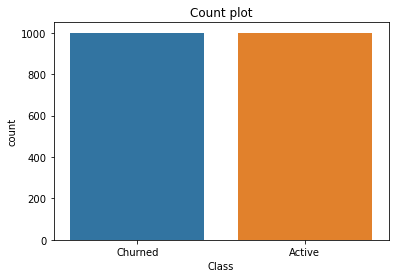

In [10]:
balance_ratio(df_churn['Class'])

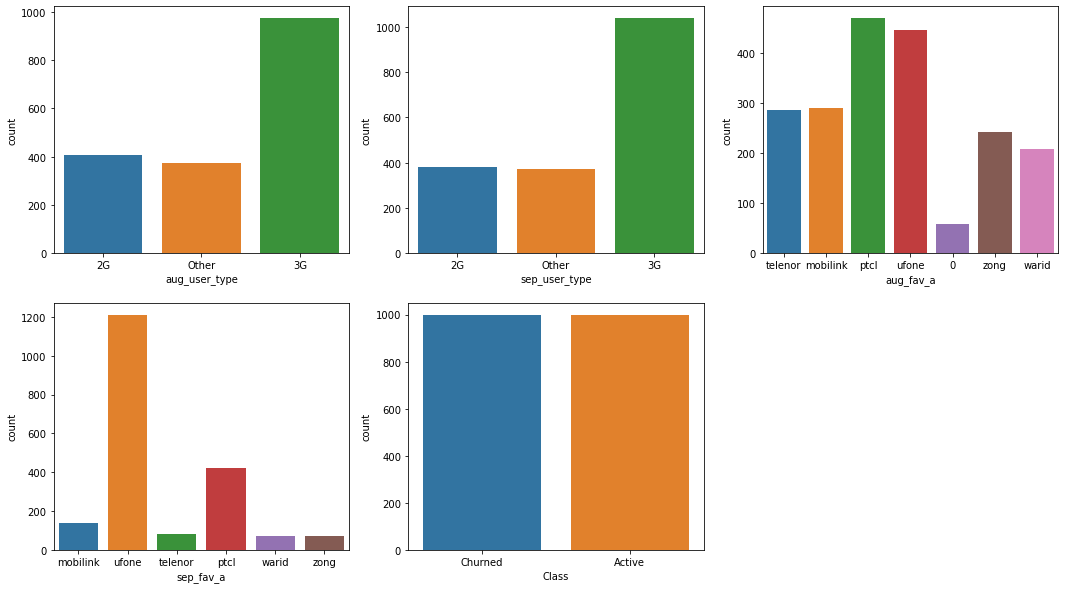

In [11]:
# we will check countplots for categorical variables
countplots(df_churn,18,10,3)

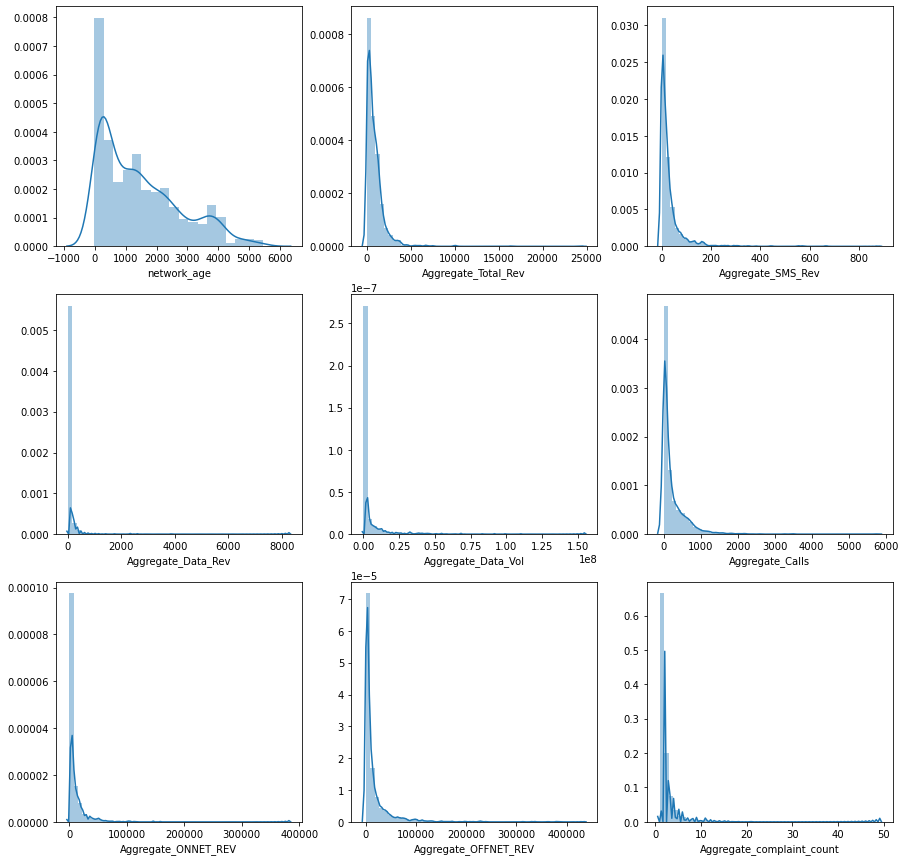

In [12]:
histogram(df_churn,15,15,3)

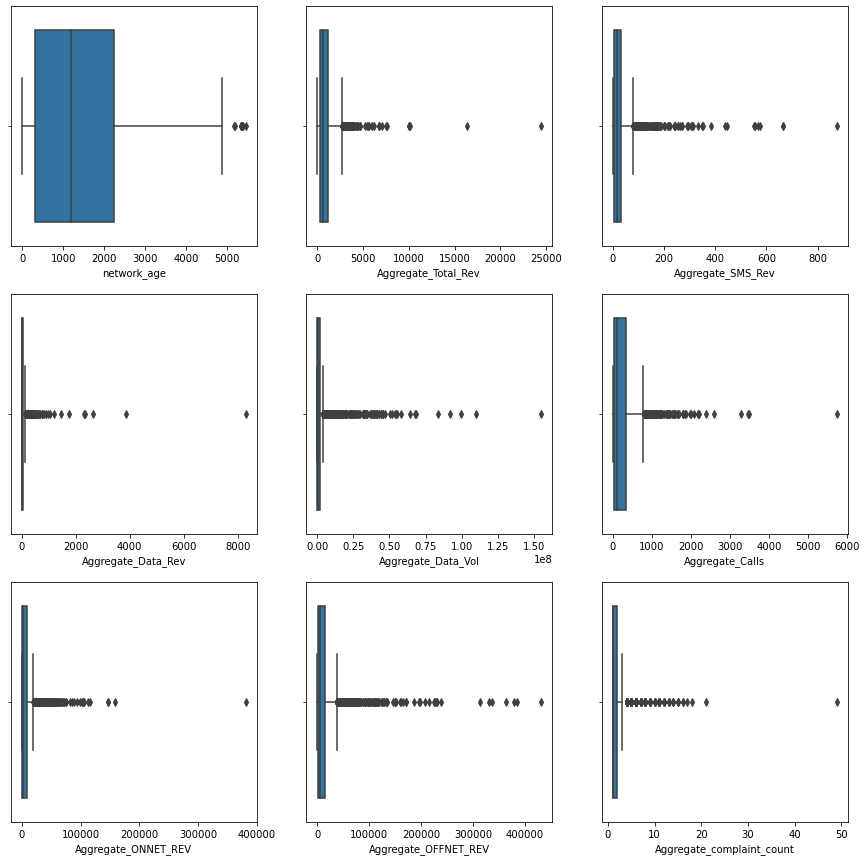

In [13]:
boxplots(df_churn,15,15,3)

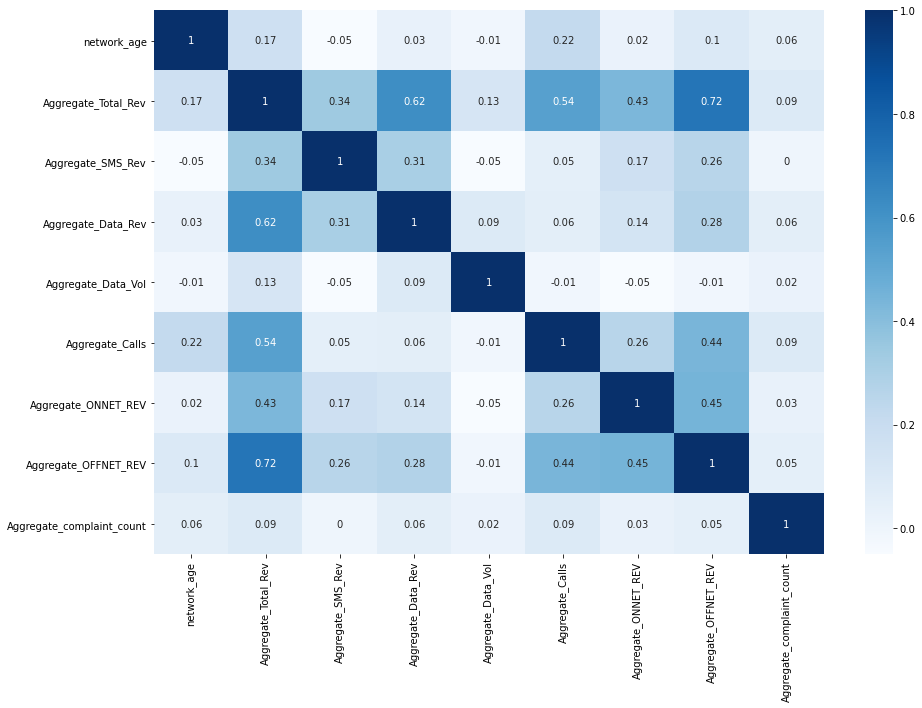

In [14]:
#Bivariate Analysis using heatmap
plt.figure(figsize=(15,10))
sns.heatmap(round(df_churn.corr(),2),annot=True,cmap='Blues')
plt.show()

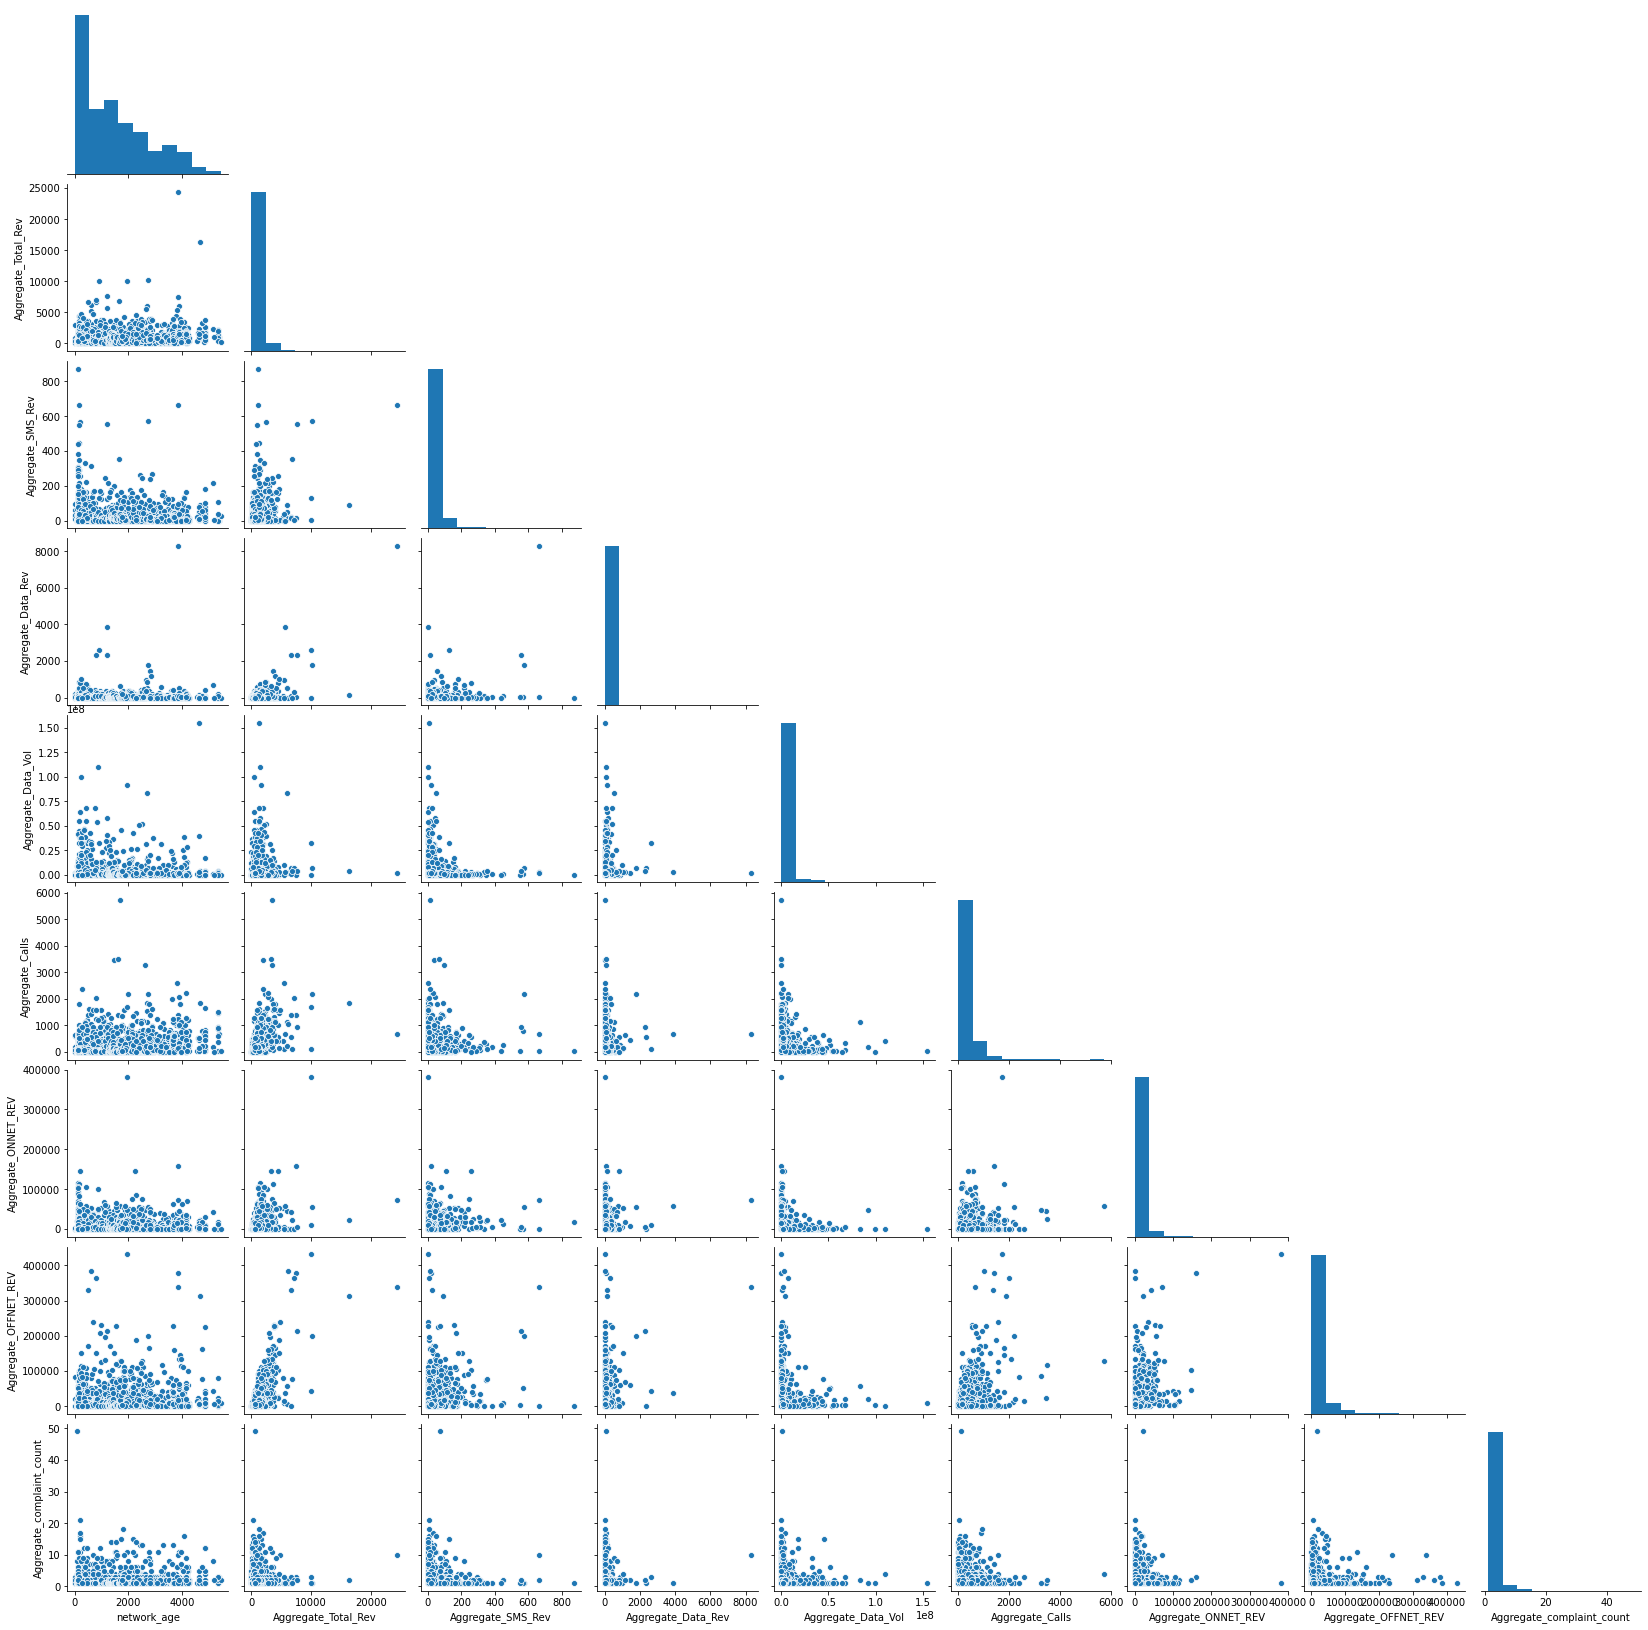

In [15]:
# pairplot
sns.pairplot(df_churn, corner=True)

In [16]:
# Checking for missing values and duplicate records
missing_duplicates(df_churn)

There are missing values in the dataset
There are 245 missing values in the feature:  aug_user_type
Percentage of missing values in the feature: 12.25 %
Percentage of missing values in total data points: 0.875 %
There are 206 missing values in the feature:  sep_user_type
Percentage of missing values in the feature: 10.3 %
Percentage of missing values in total data points: 0.736 %
There are 1 missing values in the feature:  aug_fav_a
Percentage of missing values in the feature: 0.05 %
Percentage of missing values in total data points: 0.004 %
There are 1 missing values in the feature:  sep_fav_a
Percentage of missing values in the feature: 0.05 %
Percentage of missing values in total data points: 0.004 %
There are no duplicate records found in the dataset


In [17]:
# replacing missing values with mode
df_churn['aug_user_type'].fillna(df_churn['aug_user_type'].mode()[0], inplace=True )
df_churn['sep_user_type'].fillna(df_churn['sep_user_type'].mode()[0], inplace=True )
df_churn['aug_fav_a'].fillna(df_churn['aug_fav_a'].mode()[0], inplace=True )
df_churn['sep_fav_a'].fillna(df_churn['sep_fav_a'].mode()[0], inplace=True )

In [18]:
# Checking for missing values and duplicate records after treating missing values
missing_duplicates(df_churn)

There are no missing values in the dataset
There are no duplicate records found in the dataset


In [19]:
# Getting column names
df_churn.columns

Index(['network_age', 'Aggregate_Total_Rev', 'Aggregate_SMS_Rev',
       'Aggregate_Data_Rev', 'Aggregate_Data_Vol', 'Aggregate_Calls',
       'Aggregate_ONNET_REV', 'Aggregate_OFFNET_REV',
       'Aggregate_complaint_count', 'aug_user_type', 'sep_user_type',
       'aug_fav_a', 'sep_fav_a', 'Class'],
      dtype='object')

In [20]:
# We will perform one hot encoding on all categorical variables.
# Drop_first is set to True in order to avoid multicolinearity and also it reduces number of features
# We will not encode the target variable i.e 'Class'
df_churn = pd.get_dummies(data=df_churn, columns=['aug_user_type','sep_user_type','aug_fav_a','sep_fav_a'], drop_first=True)
df_churn.head()

,network_age,Aggregate_Total_Rev,Aggregate_SMS_Rev,Aggregate_Data_Rev,Aggregate_Data_Vol,Aggregate_Calls,Aggregate_ONNET_REV,Aggregate_OFFNET_REV,Aggregate_complaint_count,Class,aug_user_type_3G,aug_user_type_Other,sep_user_type_3G,sep_user_type_Other,aug_fav_a_mobilink,aug_fav_a_ptcl,aug_fav_a_telenor,aug_fav_a_ufone,aug_fav_a_warid,aug_fav_a_zong,sep_fav_a_ptcl,sep_fav_a_telenor,sep_fav_a_ufone,sep_fav_a_warid,sep_fav_a_zong
0,1914,1592.7200,23.26,2.5,1.161130e+01,375,25523,99000,1,Churned,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
1,2073,1404.1496,174.45,27.5,2.531725e+03,389,14584,77299,1,Churned,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0
2,3139,85.5504,14.34,5.0,2.913306e+04,15,477,4194,1,Churned,0,1,0,1,0,1,0,0,0,0,0,1,0,0,0
3,139,2315.2292,19.25,52.5,2.674413e+05,636,50316,52400,2,Active,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0
4,139,227.8620,2.95,42.5,1.461621e+06,17,2568,1701,1,Active,1,0,1,0,1,0,0,0,0,0,0,0,1,0,0


In [21]:
# Function to create data imbalance for minority class
def create_imbalance1(df,target_index,Perc):
    data = df.copy()
    
    # seperating independent and dependent variables
    X = data.drop(data.columns[target_index],axis=1)
    y = data.iloc[:,target_index]
    
    # creating imbalance from given percentage
    ratio1 = int(y.value_counts().sort_values(ascending=False)[1] * (Perc/100))
    ratio2 = int(y.value_counts().sort_values(ascending=False)[1]) - ratio1
    label1 = data.iloc[:,target_index].value_counts().sort_values(ascending=False).index[1]
    label2 = data.iloc[:,target_index].value_counts().sort_values(ascending=False).index[0]
    
    #making imbalance
    X_res, y_res = make_imbalance(X, y, sampling_strategy={label1:ratio1, label2:ratio2}, random_state=1)
    target_variable = data.columns[target_index]
    X_res[target_variable] = y_res
    
    return X_res

Balance ratio of variable in Percentage
Active     65.0
Churned    35.0
Name: Class, dtype: float64



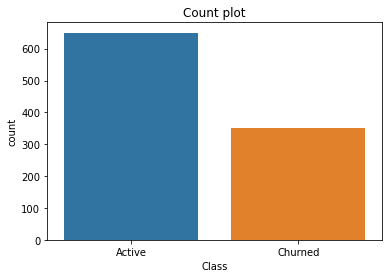

In [22]:
# creating 65:35 imbalance ratio
df_churn_65 = create_imbalance1(df_churn,9,65)
balance_ratio(df_churn_65['Class'])

Balance ratio of variable in Percentage
Active     75.0
Churned    25.0
Name: Class, dtype: float64



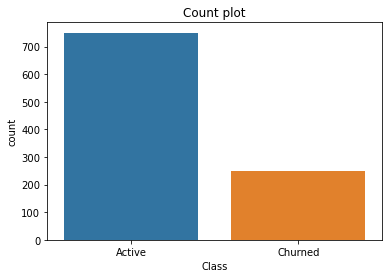

In [23]:
# creating 75:25 imbalance ratio
df_churn_75 = create_imbalance1(df_churn,9,75)
balance_ratio(df_churn_75['Class'])

Balance ratio of variable in Percentage
Active     90.0
Churned    10.0
Name: Class, dtype: float64



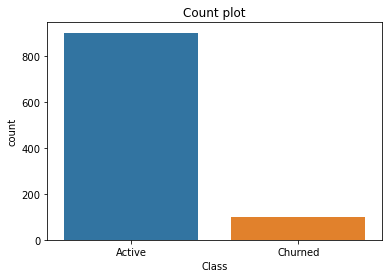

In [24]:
# creating 90:10 imbalance ratio
df_churn_90 = create_imbalance1(df_churn,9,90)
balance_ratio(df_churn_90['Class'])

In [25]:
# seperating target and features
X = df_churn_90.drop(columns=['Class'],axis=1)
y = df_churn_90['Class']
print(X.shape)
print(y.shape)

(1000, 24)
(1000,)


In [26]:
#train test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30 , random_state=1, stratify=y)

In [27]:
# checking the shape after spliting
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(700, 24)
(300, 24)
(700,)
(300,)


In [28]:
# checking the distribution of target label after split
y_train.value_counts(normalize=True)

Active     0.9
Churned    0.1
Name: Class, dtype: float64

In [29]:
# checking the distribution of target label after split
y_test.value_counts(normalize=True)

Active     0.9
Churned    0.1
Name: Class, dtype: float64

In [30]:
# training default model just to see performance measures like confusion matrix and ROC AUC curve 
model = RandomForestClassifier()
parameters = {'n_estimators':[100]}
grid = GridSearchCV(model, param_grid=parameters, cv=5)
test = grid.fit(X_train, y_train)

In [31]:
#checking train score
grid.score(X_train, y_train)

1.0

In [32]:
#checking test score
grid.score(X_test, y_test)

0.9166666666666666

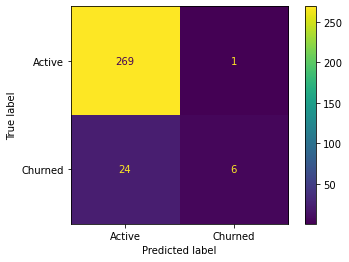

In [33]:
# checking confusion matrix for test data
metrics.plot_confusion_matrix(test,X_test,y_test)
plt.show()

AUC for the Training Data: 1.000
AUC for the Test Data: 0.858


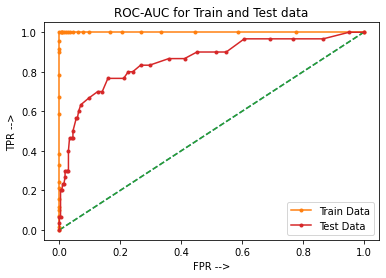

In [34]:
# Training Data Probability Prediction
pred_prob_train_RF_T = test.predict_proba(X_train)
pred_prob_test_RF_T = test.predict_proba(X_test)

#AUC & ROC for Train Data
auc = metrics.roc_auc_score(y_train,pred_prob_train_RF_T[:,1])
print('AUC for the Training Data: %.3f' % auc)
fpr, tpr, thresholds = metrics.roc_curve(y_train,pred_prob_train_RF_T[:,1],pos_label = ['Churned'])
plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot(fpr, tpr, marker='.',label = 'Train Data')

#AUC & ROC for Test Data
auc = metrics.roc_auc_score(y_test,pred_prob_test_RF_T[:,1])
print('AUC for the Test Data: %.3f' % auc)
fpr, tpr, thresholds = metrics.roc_curve(y_test,pred_prob_test_RF_T[:,1],pos_label = ['Churned'])
plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot(fpr, tpr, marker='.',label='Test Data')

plt.legend(loc='best')
plt.xlabel('FPR -->')
plt.ylabel('TPR -->')
plt.title('ROC-AUC for Train and Test data')
plt.show()